# Nortek AD2CP Processing, Testing, and Data Exploration

jgradone@marine.rutgers.edu     01/11/2022      Initial
jgradone@marine.rutgers.edu     09/15/2025      Edited after changes to be more package-like

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>


*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports
from scipy.sparse.linalg import lsqr
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import math
import xarray as xr
import time
import gsw
import slocum_ad2cp
import netCDF4
import h5netcdf




## Step 1: Load glider data

In [ ]:
ds_id = 'ru29-20240419T1430-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy', 'm_heading','m_gps_mag_var']
gdf = slocum_ad2cp.get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

## Step 2: Load in AD2CP data frame

In [ ]:

def load_ad2cp(ncfile, mean_lat=15):
    """
    Load single or multiple AD2CP NetCDF files.
    
    Tries 'Data/Average/' first, then 'Data/Burst/' if no data in Average.
    Converts Pressure to Depth and drops Pressure.
    
    Parameters
    ----------
    ncfile : str or list of str
        Path to a single NetCDF file or list of files.
    mean_lat : float
        Latitude for converting Pressure to Depth.
    
    Returns
    -------
    ds : xarray.Dataset
        Combined dataset with Depth variable.
    group : str
        Group that was loaded ('Average' or 'Burst').
    """
    # Ensure list of Python strings
    files = [str(f) for f in (ncfile if isinstance(ncfile, list) else [ncfile])]
    group = None
    ds = None

    # Try Average group
    try:
        if len(files) == 1:
            ds = xr.open_dataset(files[0], group="Data/Average/")
        else:
            ds = xr.open_mfdataset(
                files,
                group="Data/Average/",
                concat_dim="time",
                combine="nested",
                engine="netcdf4"
            )
        if ds.time.size > 0:
            group = "Average"
    except Exception:
        pass

    # Fallback to Burst group
    if group is None:
        try:
            if len(files) == 1:
                ds = xr.open_dataset(files[0], group="Data/Burst/")
            else:
                ds = xr.open_mfdataset(
                    files,
                    group="Data/Burst/",
                    concat_dim="time",
                    combine="nested",
                    engine="netcdf4"
                )
            if ds.time.size > 0:
                group = "Burst"
        except Exception:
            raise ValueError("Neither 'Average' nor 'Burst' groups contain data")

    # Sort by time
    ds = ds.sortby("time")

    # Attach attributes from Config group of first file
    config = xr.open_dataset(ncfile[0], group="Config")
    ds = ds.assign_attrs(config.attrs)

    # Rename variables for consistency
    rename_map = {
        "Velocity Range": "VelocityRange",
        "Correlation Range": "CorrelationRange",
        "Amplitude Range": "AmplitudeRange"
    }
    ds = ds.rename({k: v for k, v in rename_map.items() if k in ds.variables})

    # Convert Pressure -> Depth
    if "Pressure" in ds.variables:
        ds = ds.assign(Depth=("time", -gsw.z_from_p(ds.Pressure.values, mean_lat)))
        ds = ds.drop_vars("Pressure")

    ds = ds.transpose()

    return ds

file = "../raw_data/RU29_Test_AD2CP_1.nc"
file
tot_ad2cp = slocum_ad2cp.load_ad2cp(file,mean_lat=15)


/Users/joegradone/anaconda3/envs/slocum_ad2cp/lib/python3.11/site-packages/slocum_ad2cp/make_dataset.py:823: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(ncfile, group="Data/Average/", concat_dim="time", combine="nested")


## Step 3: Subset datasets
Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data

In [ ]:
x=21

## Subset glider df to one segment
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
## Pull out last non-NaN DAC
ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
vx_lon      = np.nanmean(subsetgdf.longitude)
vx_lat      = np.nanmean(subsetgdf.latitude)
vx_start_tm = subsetgdf.time.iloc[0]
vx_end_tm   = subsetgdf.time.iloc[-1]

## Subset AD2CP dataframe based on segment start and end times
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_5451/3020911126.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


## Take a quick peak at some data

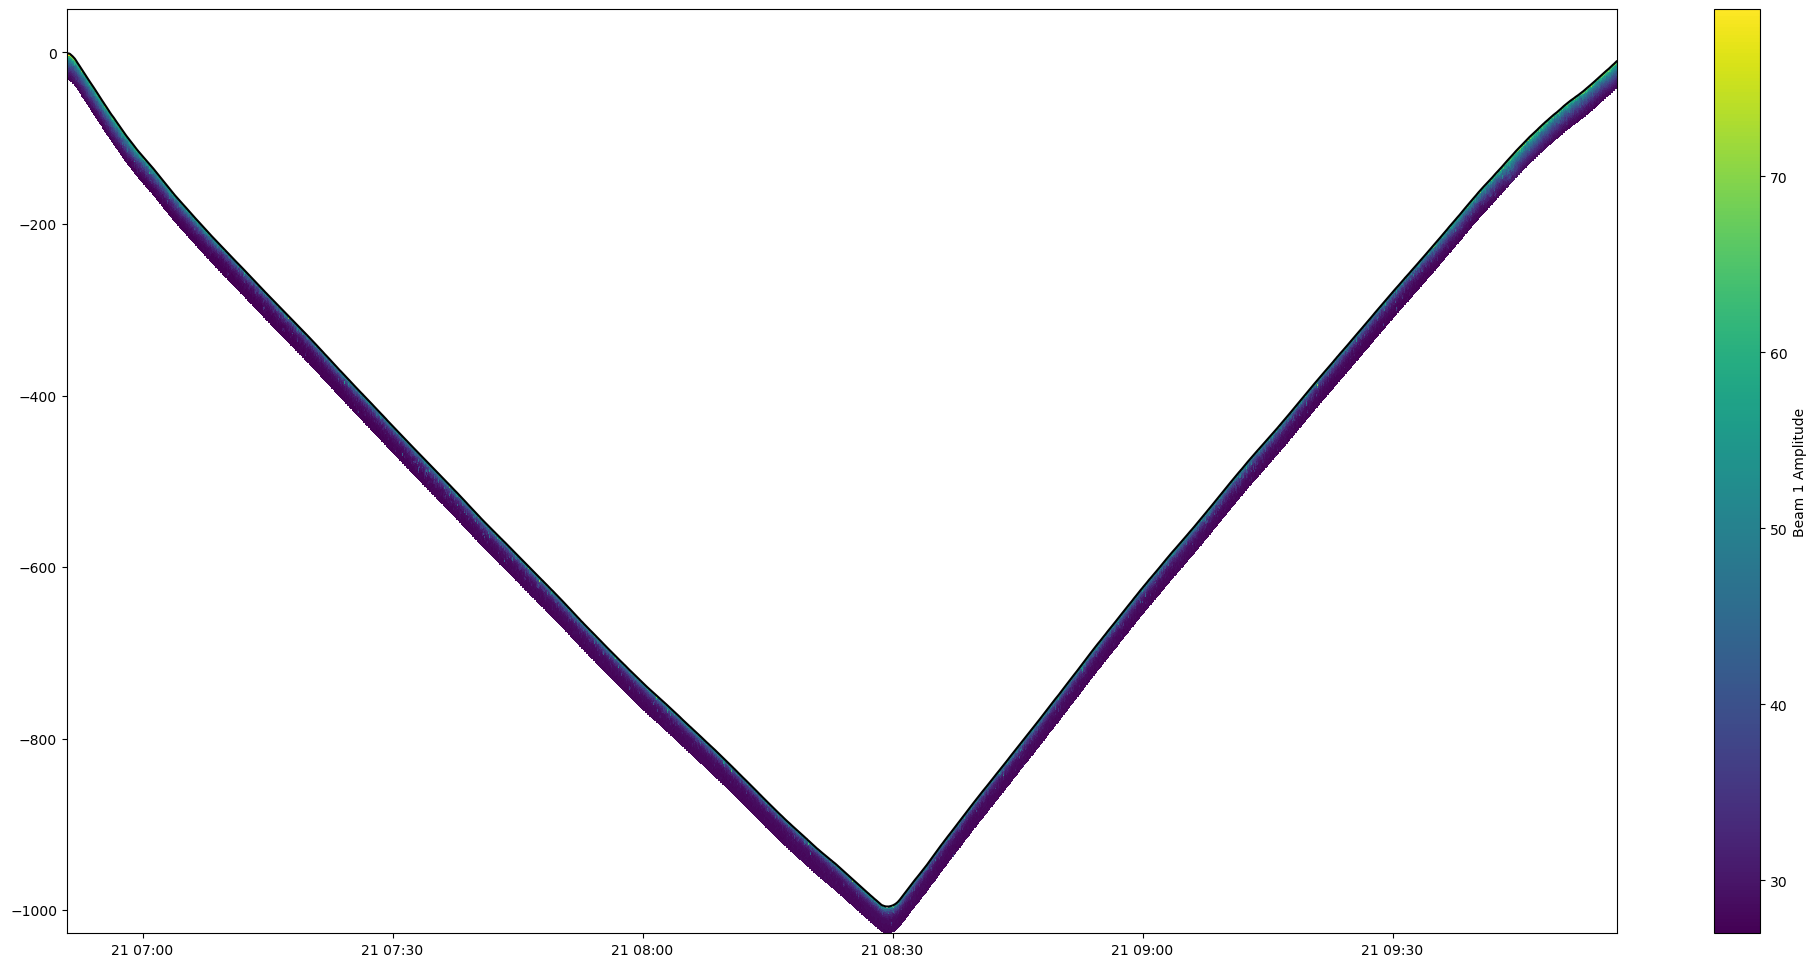

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Beam 1 Amplitude')


### Zoomed in peak at data

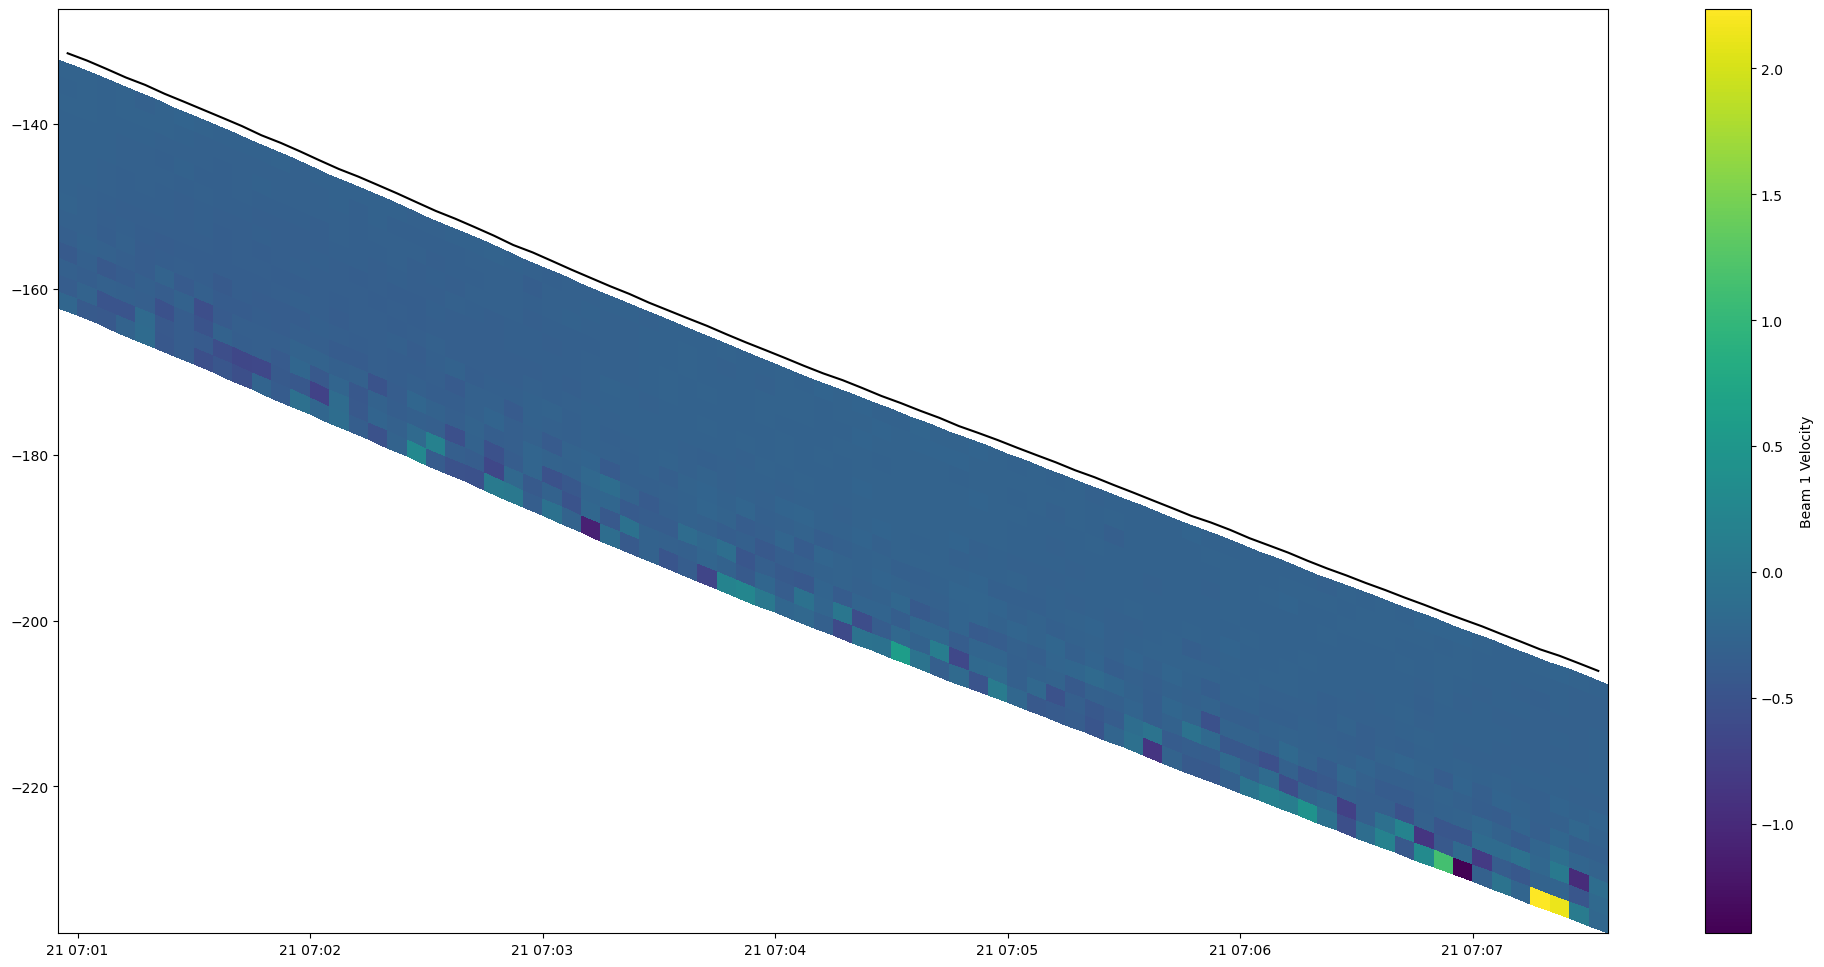

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 120
end_ind   = 200

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')


## Step 4: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

In [ ]:
np.max(subset_ad2cp.VelocityBeam1.values)

np.float32(3.005)

In [ ]:
# Correct for local speed of sound
subset_ad2cp = slocum_ad2cp.correct_sound_speed(subset_ad2cp)

In [ ]:
np.max(subset_ad2cp.VelocityBeam1.values)

np.float32(2.9997916)

### Take a peak at the speed of sound corrected data

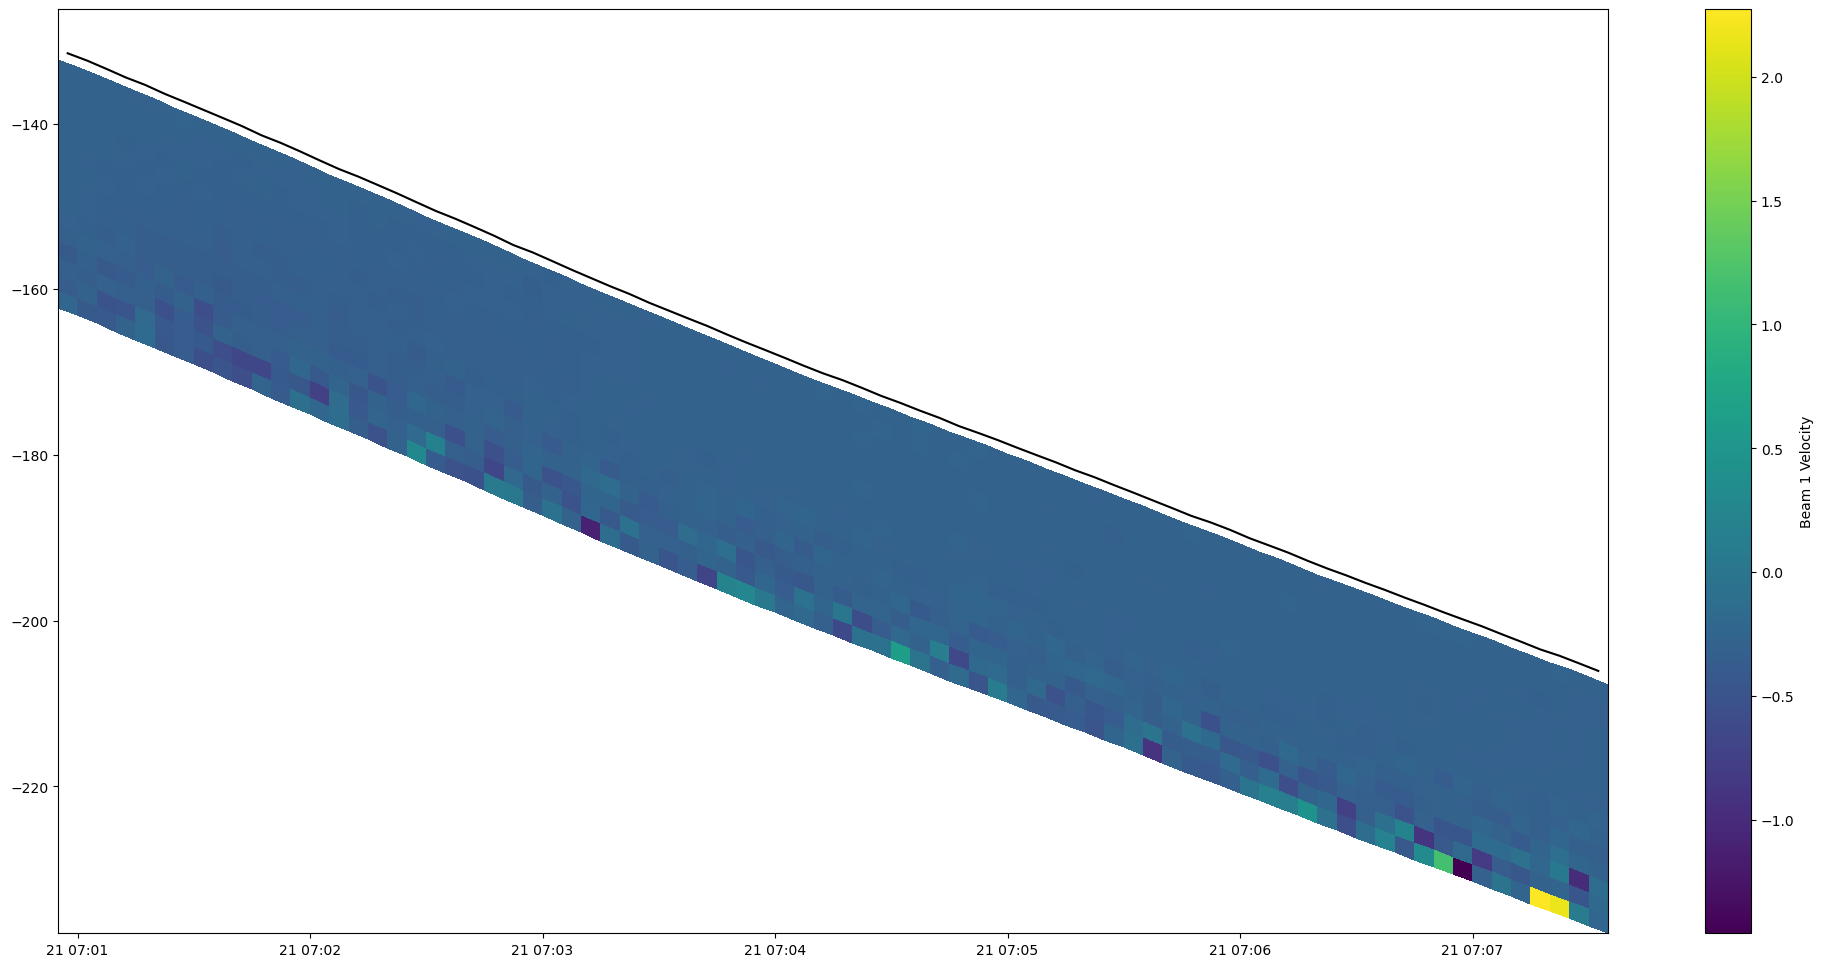

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 120
end_ind   = 200

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')


## Step 5: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [ ]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

np.float32(-0.27093205)

In [ ]:
## QAQC pre-coordinate transformation
subset_ad2cp = slocum_ad2cp.qaqc_pre_coord_transform(subset_ad2cp, corr_threshold = 50, max_amplitude = 75)

In [ ]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

np.float32(-0.28045395)

### Take a peak at the QAQC'd data

NameError: name 'myFmtlong' is not defined

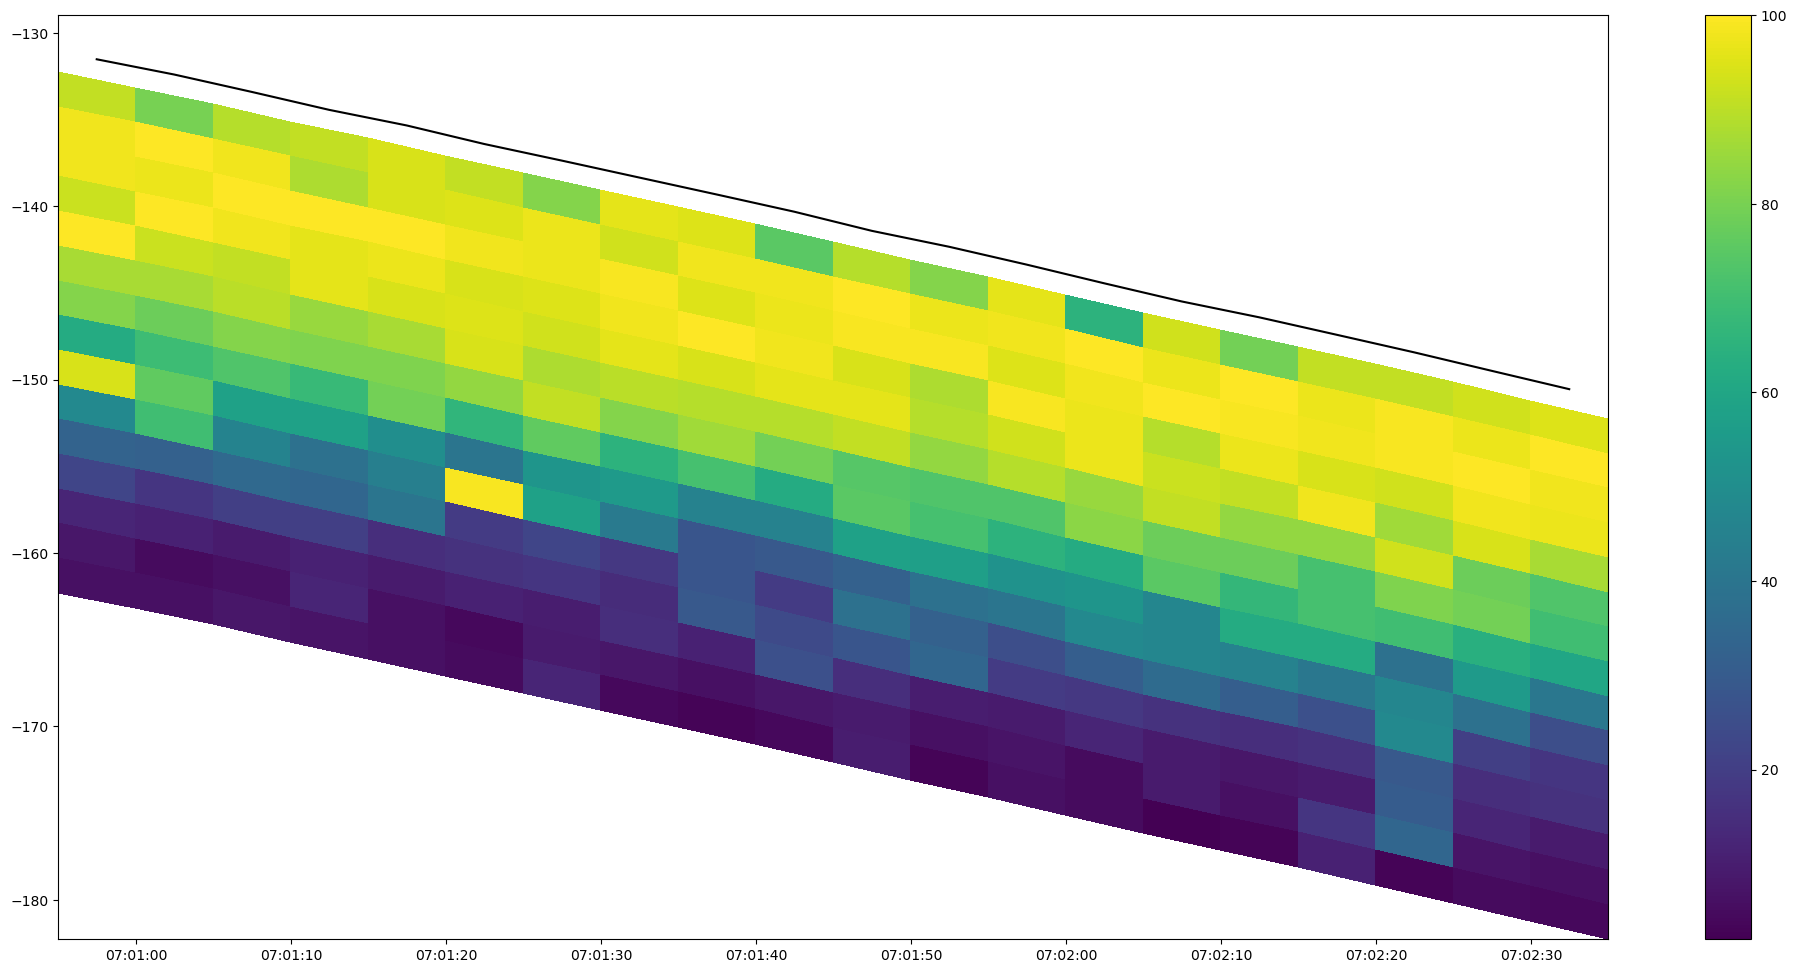

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 120
end_ind   = 140


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar()
#plt.colorbar(label='Beam 1 Correlation')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_18442/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


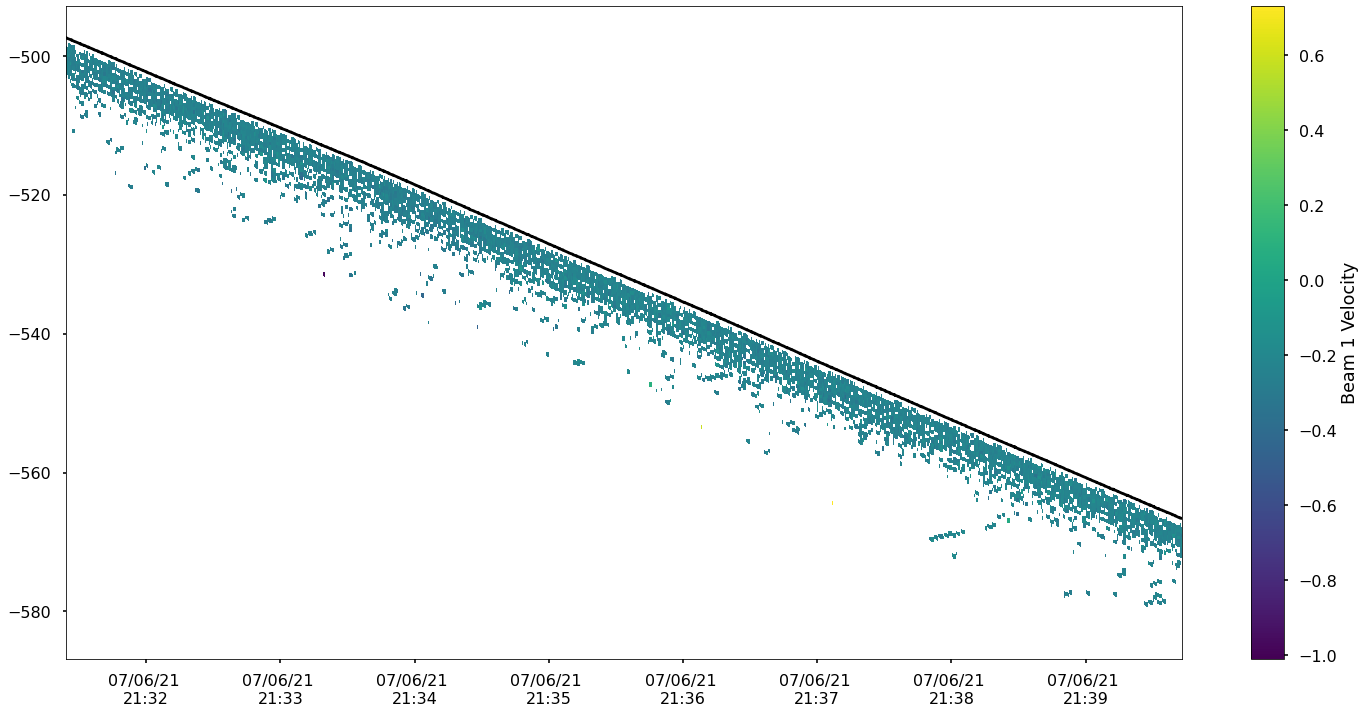

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 6: Correct beams to level true-depth

In [ ]:
## Correct beams to level true-depth
subset_ad2cp = slocum_ad2cp.beam_true_depth(subset_ad2cp)

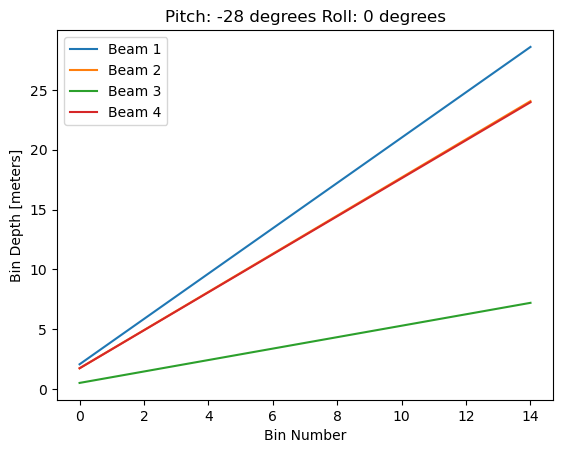

In [ ]:
x=20
plt.plot(subset_ad2cp.TrueDepthBeam1.values[:,x],label='Beam 1')
plt.plot(subset_ad2cp.TrueDepthBeam2.values[:,x],label='Beam 2')
plt.plot(subset_ad2cp.TrueDepthBeam3.values[:,x],label='Beam 3')
plt.plot(subset_ad2cp.TrueDepthBeam4.values[:,x],label='Beam 4')
plt.ylabel('Bin Depth [meters]')
plt.xlabel('Bin Number')
plt.title('Pitch: %i' %subset_ad2cp['Pitch'].values[x] + ' degrees Roll: %i' %subset_ad2cp['Roll'].values[x] + ' degrees')
plt.legend()

## Processing Step 7: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [ ]:
## Bin map
subset_ad2cp = slocum_ad2cp.binmap_adcp(subset_ad2cp)

In [ ]:
subset_ad2cp

<xarray.Dataset> Size: 4MB
Dimensions:                    (VelocityRange: 15, time: 2232,
                                CorrelationRange: 15, AmplitudeRange: 15,
                                Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 18kB 2024-04-21T06:50:57...
  * VelocityRange              (VelocityRange) float32 60B 2.2 4.2 ... 28.2 30.2
  * CorrelationRange           (CorrelationRange) float32 60B 2.2 4.2 ... 30.2
  * AmplitudeRange             (AmplitudeRange) float32 60B 2.2 4.2 ... 30.2
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/53)
    VelocityBeam1              (VelocityRange, time) float32 134kB nan ... nan
    VelocityBeam2              (VelocityRange, time) float32 134kB nan ... nan
    VelocityBeam3              (VelocityRange, time) float32 134kB nan ... nan
    VelocityBeam4              (VelocityRange, time) float32 134kB nan ... nan
    CorrelationBeam1           (CorrelationRange, time) float32 134kB dask.array<chunksize=(15, 2232), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 134kB dask.array<chunksize=(15, 2232), meta=np.ndarray>
    ...                         ...
    TrueDepthBeam4             (VelocityRange, time) float64 268kB 1.968 ... ...
    TrueDepth                  (VelocityRange, time) float64 268kB 3.113 ... ...
    InterpVelocityBeam1        (VelocityRange, time) float64 268kB nan ... nan
    InterpVelocityBeam2        (VelocityRange, time) float64 268kB nan ... nan
    InterpVelocityBeam3        (VelocityRange, time) float64 268kB nan ... nan
    InterpVelocityBeam4        (VelocityRange, time) float64 268kB nan ... nan
Attributes: (12/350)
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...
    File_ins_runTime:                             442996000.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               0
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    exportRevision:                               4489

### Take a peak at the bin mapped data

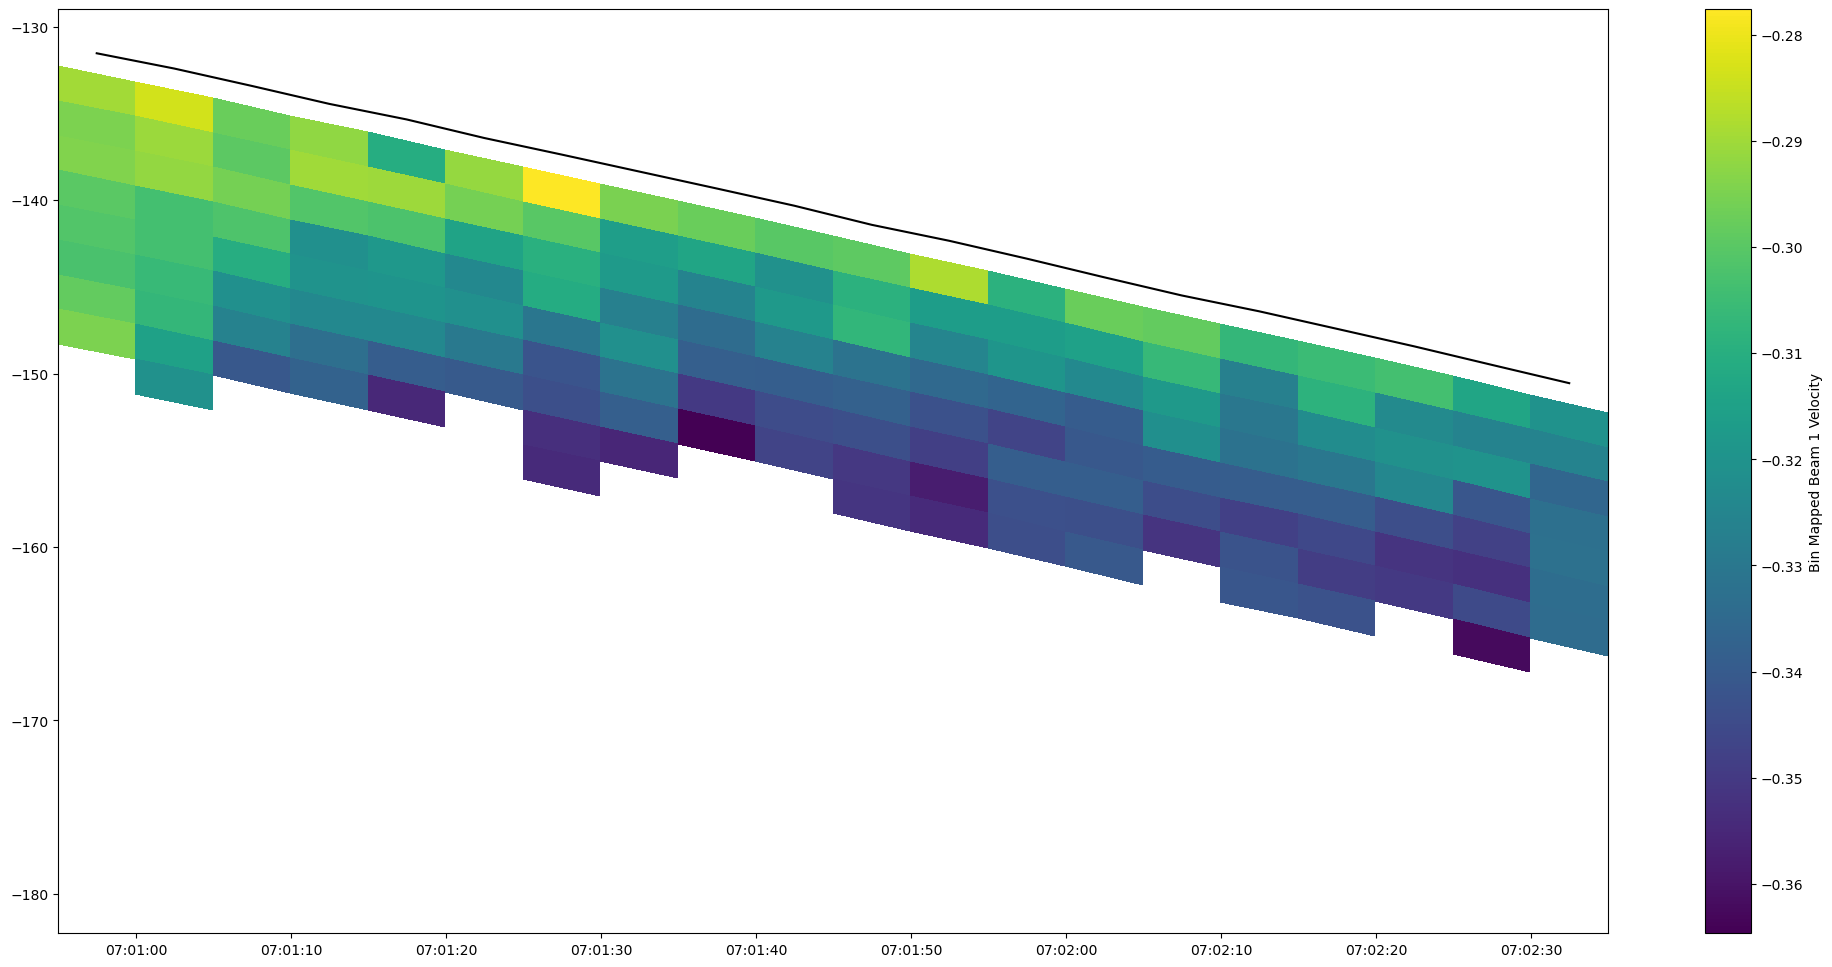

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 120
end_ind   = 140

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Bin Mapped Beam 1 Velocity')


## Processing Step 8: Correct heading for local magnetic delcination and local magnetic field

In [ ]:
subset_ad2cp = slocum_ad2cp.correct_ad2cp_heading(subset_ad2cp)
subset_ad2cp = slocum_ad2cp.calcAHRS(subset_ad2cp)


ValueError: Must have at least 9 points to fit a unique ellipsoid

## Processing Step 9: Convert from Beam to XYZ to ENU coordinates

In [69]:
## Beam to ENU
subset_ad2cp = slocum_ad2cp.beam2enu(subset_ad2cp)

No beam transformation matrix info found


UnboundLocalError: cannot access local variable 'beam2xyz' where it is not associated with a value

### Take a peak at ENU data

/tmp/ipykernel_18442/2605771011.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


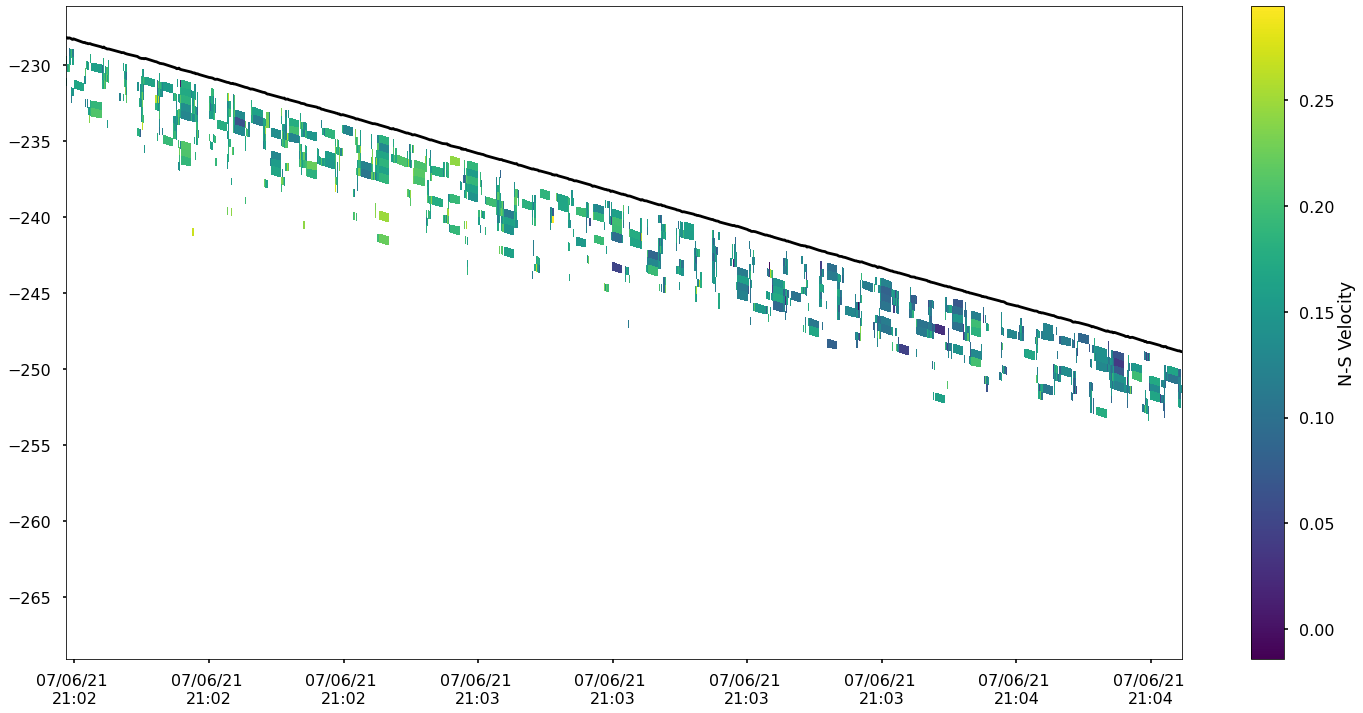

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 5000
end_ind   = 5500

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_18442/3852730933.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])


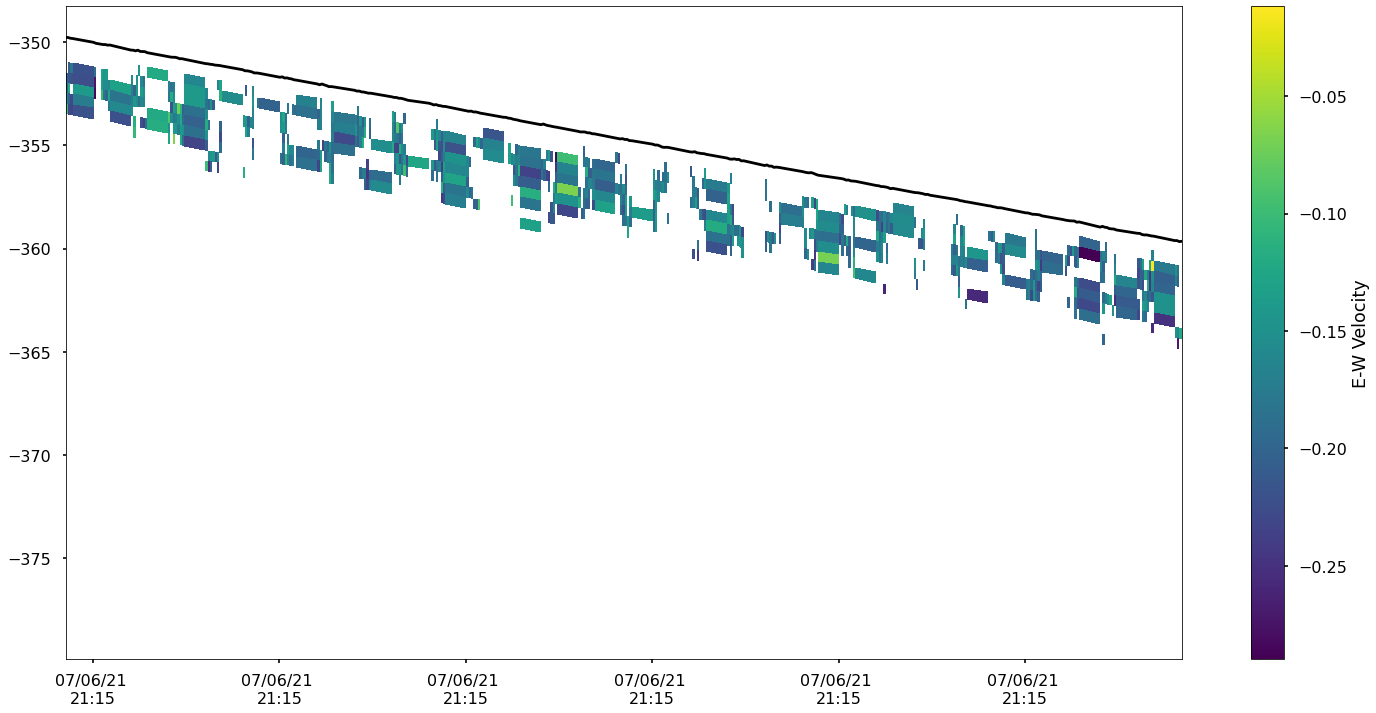

In [27]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins


# start_ind = 200
# end_ind   = 850

# start_ind = 800
# end_ind   = 1500

start_ind = 8060
end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='E-W Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_18442/1668302072.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


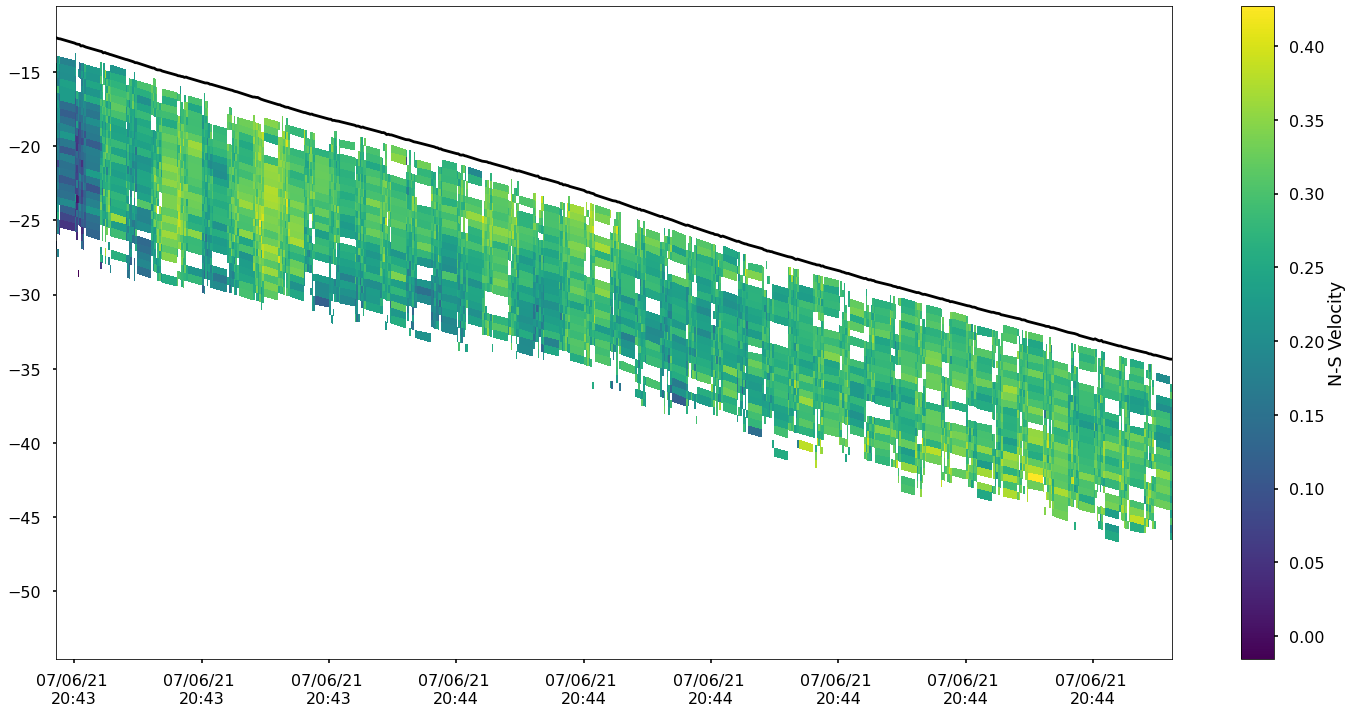

In [28]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 500
end_ind   = 850

# start_ind = 8060
# end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [29]:
subset_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 45961, VelocityRange: 40,
                                CorrelationRange: 40, AmplitudeRange: 40,
                                Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-06T20:41:24.0320...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/64)
    VelocityBeam1              (VelocityRange, time) float32 nan nan ... -0.034
    VelocityBeam2              (VelocityRange, time) float32 nan nan ... 0.341
    VelocityBeam3              (VelocityRange, time) float32 nan nan ... 0.234
    VelocityBeam4              (VelocityRange, time) float32 nan nan ... -0.043
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 45961), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 45961), meta=np.ndarray>
    ...                         ...
    InterpVelocityBeam2        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam3        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam4        (VelocityRange, time) float64 nan nan ... nan nan
    UVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
    VVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
    WVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

## Filter out really high velocities relative to glider and first bin below glider

/tmp/ipykernel_18442/3394160177.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


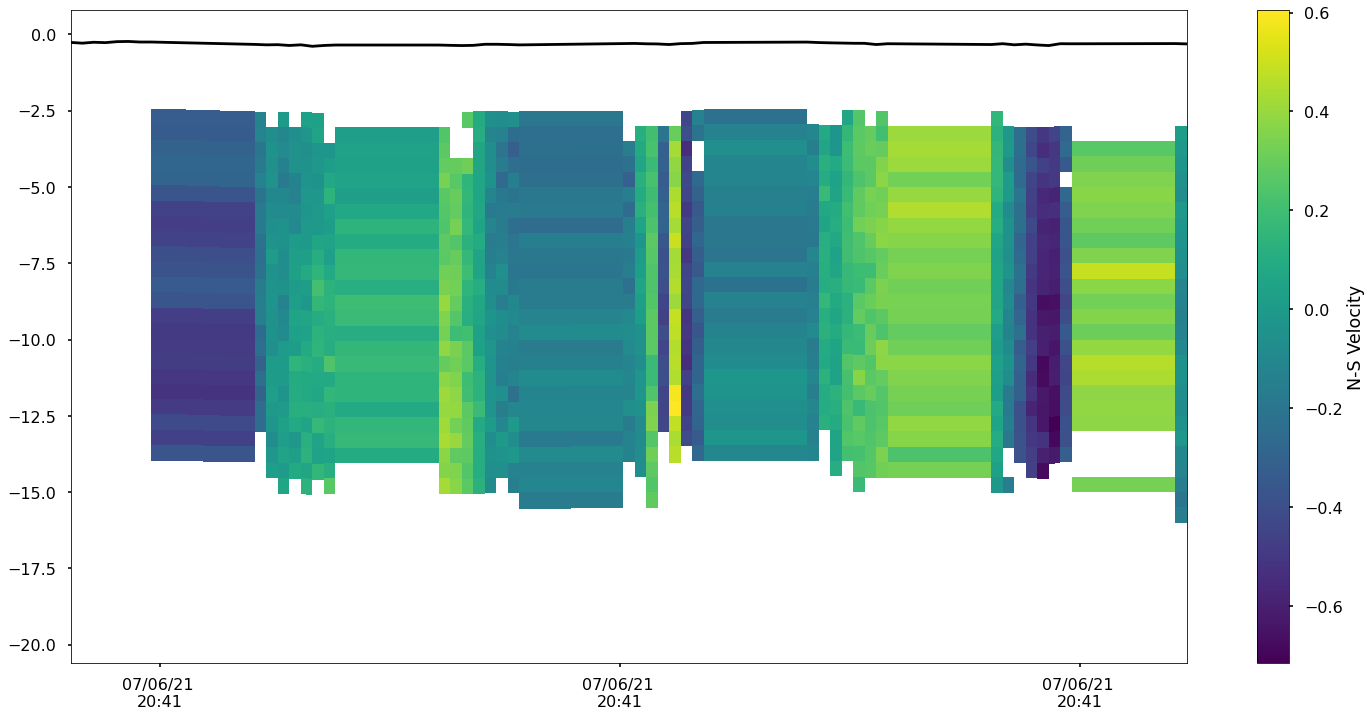

In [30]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 0
end_ind   = 50

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [31]:
subset_ad2cp = qaqc_post_coord_transform(subset_ad2cp, high_velocity_threshold=0.75, surface_depth_to_filter = 5)

/tmp/ipykernel_18442/664111595.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')


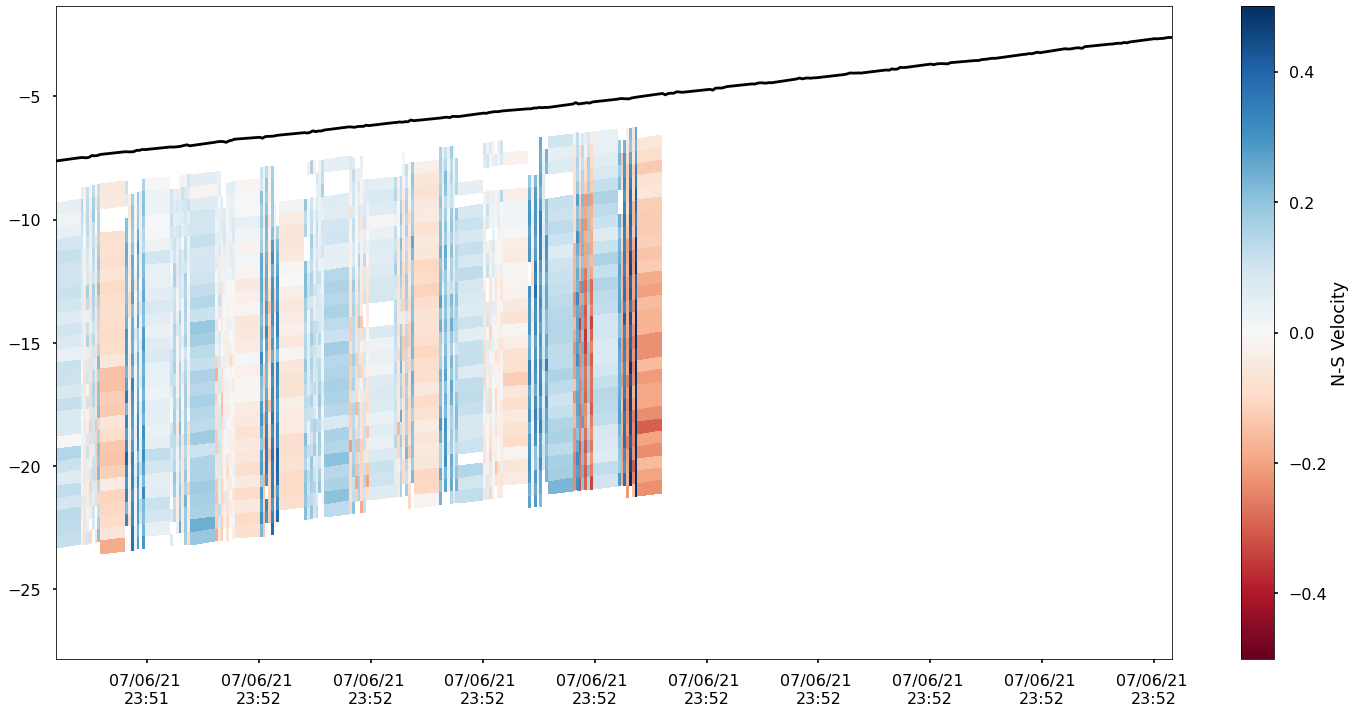

In [32]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

#start_ind = 350
#end_ind   = 550

start_ind = -250
end_ind   = -50


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_18442/431571487.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')


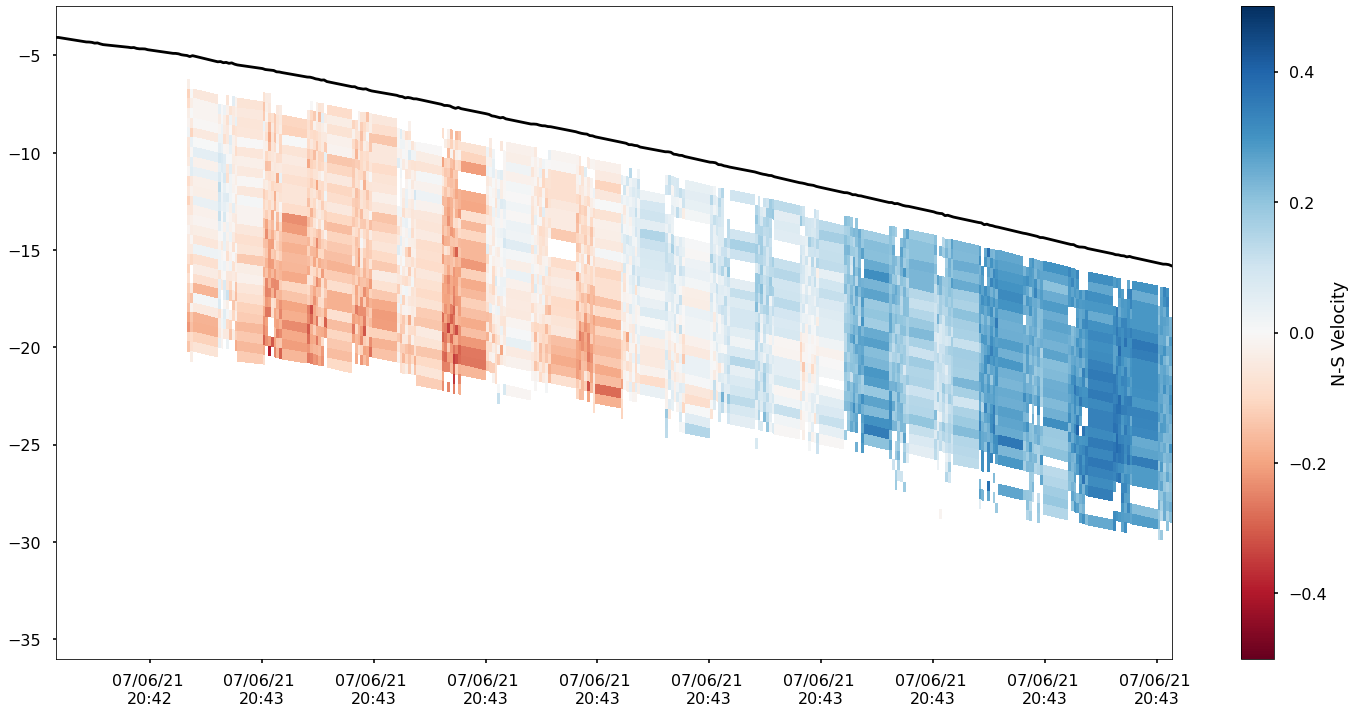

In [33]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 350
end_ind   = 550

#start_ind = -250
#end_ind   = -50


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 9: Run the inversion!

In [34]:
start_time = time.time()

U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
dz=10
u_daverage=vx
v_daverage=vy
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values
wDAC = 5
wSmoothness = 1


## Feb-2021 jgradone@marine.rutgers.edu Initial
## Jul-2021 jgradone@marine.rutgers.edu Updates for constraints
## Jun-2022 jgradone@marine.rutgers.edu Corrected dimensions and indexing of G matrix
## Jun-2022 jgradone@marine.rutgers.edu Added curvature minimizing constraint and constraint weights

## Purpose: Take velocity measurements from glider mounted ADCP and compute
# shear profiles

## Outputs:
# O_ls is the ocean velocity profile
# G_ls is the glider velocity profile
# bin_new are the bin centers for the point in the profiles
# obs_per_bin is the number of good velocity observations per final profile bin

## Inputs:
# dz is desired vertical resolution, should not be smaller than bin length
# U is measured east-west velocities from ADCP
# V is measured north-south velocities from ADCP
# bins is the bin depths for the U and V measurements
# uv_daverage is depth averaged velocity (Set to 0 for real-time)
# depth is the depth of the glider measured by the ADCP
# wDAC is the weight of the DAC constraint (5 per Todd et al. 2017)
# wSmoothness is the weight of the curvature minimizing contraint


#########################################################################  
## These steps filter for NAN rows and columns so they are technically QAQC
## but I think the best place to put them is inthe inversion function because
## if there are NaNs still present in the data here, it will throw everything off
## These steps are HUGE for efficiency because it reduces the size of the G
## matrix as much as possible.

## This determines the rows (bins) where all the columns are NaN
nanind = np.where( (np.sum(np.isnan(U),axis=1)/U.shape[1]) == 1)[0]
if len(nanind) > 0:
    U = np.delete(U,nanind,axis=0)
    V = np.delete(V,nanind,axis=0)
    bins = np.delete(bins,nanind)

## Do the same thing with individual ensembles. Note: need to remove the corresponding
## ensemble pressure reading to ensure correction dimensions and values.
nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
if len(nanind) > 0:
    U = np.delete(U,nanind,axis=1)
    V = np.delete(V,nanind,axis=1)
    depth = np.delete(depth,nanind)
##########################################################################        


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth
# Calculate the maximum depth of glider which is different than maximum ADCP bin depth
ZmM = np.nanmax(depth)
##########################################################################        


##########################################################################        
# Set knowns from Equations 19 from Visbeck (2002) page 800
# Maximum number of observations (nd) is given by the number of velocity
# estimates per ping (nbin) times the number of profiles per cast (nt)
nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
nt   = U.shape[1]  # number of individual velocity profiles
nd   = nbin*nt      # G dimension (1) 

# Define the edges of the bins
bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

# Check that each bin has data in it
bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
bin_count[:] = np.NaN

for k in np.arange(len(bin_edges))[:-1]:
    # Create index of depth values that fall inside the bin edges
    ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
    bin_count[k] = len(bin_depth[ii])
    ii = []

# Create list of bin centers    
bin_new = [x+dz/2 for x in bin_edges[:-1]]
      
# Calculate which FINAL solution bin is deeper than the maximum depth of the glider
# This is done so that the depth averaged velocity constraint is only applied to bins shallower than this depth
depth_ind = len(np.where(bin_new>ZmM)[0])
# Chop off the top of profile if no data
ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
bin_new = bin_new[ind:]        # Removes all bins above first with data
z1 = bin_new[0]                # Depth of center of first bin with data
##########################################################################        


##########################################################################        
# Create and populate G
nz = len(bin_new)  # number of ocean velocities desired in output profile
nm = nt + nz       # G dimension (2), number of unknowns
# Let's build the corresponding coefficient matrix G 
G = scipy.sparse.lil_matrix((nd, nm), dtype=float)

# Indexing of the G matrix was taken from Todd et al. 2012
for ii in np.arange(0,nt):           # Number of ADCP ensembles per segment
    for jj in np.arange(0,nbin):     # Number of measured bins per ensemble 
                
        # Uctd part of matrix
        G[(nbin*(ii))+jj,ii] = -1
        # This will fill in the Uocean part of the matrix. It loops through
        # all Z members and places them in the proper location in the G matrix
        # Find the difference between all bin centers and the current Z value        
        dx = abs(bin_new-Z[jj,ii])
        # Find the minimum of these differences
        minx = np.nanmin(dx)
        # Finds bin_new index of the first match of Z and bin_new    
        idx = np.argmin(dx-minx)
        
        # Uocean part of matrix
        G[(nbin*(ii))+jj,(nt)+idx] = 1
        
        del dx, minx, idx
        
##########################################################################        
# Reshape U and V into the format of the d column vector (order='F')
# Based on how G is made, d needs to be ensembles stacked on one another vertically
d_u = U.flatten(order='F')
d_v = V.flatten(order='F')

##########################################################################
## This chunk of code containts the constraints for depth averaged currents
# Make sure the constraint is only applied to the final ocean velocity bins that the glider dives through
# Don't apply it to the first bin and don't apply it to the bins below the gliders dive depth
constraint = np.concatenate(([np.zeros(nt)], [0], [np.tile(dz,nz-(1+depth_ind))], [np.zeros(depth_ind)]), axis=None)

# Ensure the L^2 norm of the constraint equation is unity
constraint_norm = np.linalg.norm(constraint/ZmM)
C = 1/constraint_norm
constraint_normalized = (C/ZmM)*constraint ## This is now equal to 1 (unity)
# Build Gstar and add weight from todd 2017
## Some smarts would be to calculate signal to noise ratio first
Gstar = scipy.sparse.vstack((G,wDAC*constraint_normalized), dtype=float)


# Add the constraint for the depth averaged velocity from Todd et al. (2017)
du = np.concatenate(([d_u],[wDAC*C*u_daverage]), axis=None)
dv = np.concatenate(([d_v],[wDAC*C*v_daverage]), axis=None)
d = np.array(list(map(complex,du, dv)))


##########################################################################        
#### THIS removes all NaN elements of d AND Gstar so the inversion doesn't blow up with NaNs
ind2 = np.where(np.isnan(d)==True)[0]
d = np.delete(d,ind2)

def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

Gstar = delete_rows_csr(Gstar.tocsr().copy(),ind2)

#########################################################################        
# Test adding depth for tracking bin location
# d is ensembles stacked on one another vertically so same for Z (order='F')
Z_filt = Z.flatten(order='F')
Z_filt = np.delete(Z_filt,ind2)
Z_filt = np.concatenate(([Z_filt],[0]), axis=None)

##########################################################################        
## Calculation the number of observations per bin
obs_per_bin = np.empty(len(bin_new))
obs_per_bin[:] = np.NaN

for x in np.arange(0,nz):
    rows_where_nt_not_equal_zero = np.where(Gstar.tocsr()[0:Z_filt.shape[0],nt+x].toarray() > 0 )[0]
    obs_per_bin[x] = len(rows_where_nt_not_equal_zero)

## If there is no data in the last bin, drop that from the G matrix, bin_new, and obs_per_bin
if obs_per_bin[-1] == 0:
    Gstar.tocsr()[:,:-1]
    bin_new = bin_new[:-1]
    obs_per_bin = obs_per_bin[:-1]
    ## Update nz and nt
    nz = len(bin_new)
    nt = Gstar.shape[1]-nz
    
##########################################################################        
## Run the Least-Squares Inversion pre smoothing
x = lsqr(Gstar, d)[0]

O_ls = x[nt:]
G_ls = x[0:nt]

##########################################################################        
## Smoothness constraint
## Only do this is the smoothness constraint is set
if wSmoothness > 0:
    ## Add a vector of zerosm the length of nz, twice to the bottom of the data column vector
    d = np.concatenate(([d],[np.zeros(nz)],[np.zeros(nz)]), axis=None)
    ## Constraint on smoothing Uocean side of matrix
    smoothing_matrix_Uocean = scipy.sparse.diags([[-1],[2],[-1]], [0,1,2], shape=(nz,nz))
    smoothing_matrix1 = scipy.sparse.hstack((np.zeros((nz,nt)),smoothing_matrix_Uocean), dtype=float)
    ## Constraint on smoothing Uglider side of matrix
    smoothing_matrix_Uglider = scipy.sparse.diags([[-1],[2],[-1]], [0,1,2], shape=(nz,nt))
    smoothing_matrix2 = scipy.sparse.hstack((smoothing_matrix_Uglider,np.zeros((nz,nz))), dtype=float)
    Gstar = scipy.sparse.vstack((Gstar,wSmoothness*smoothing_matrix1,wSmoothness*smoothing_matrix2), dtype=float)

    
##########################################################################        
## Run the Least-Squares Inversion!
x = lsqr(Gstar, d)[0]

O_ls_smooth = x[nt:]
G_ls_smooth = x[0:nt] 
########################################################################## 
       
#return(O_ls, G_ls, bin_new, obs_per_bin)


print("My program took", time.time() - start_time, "to run")

My program took 101.65502190589905 to run


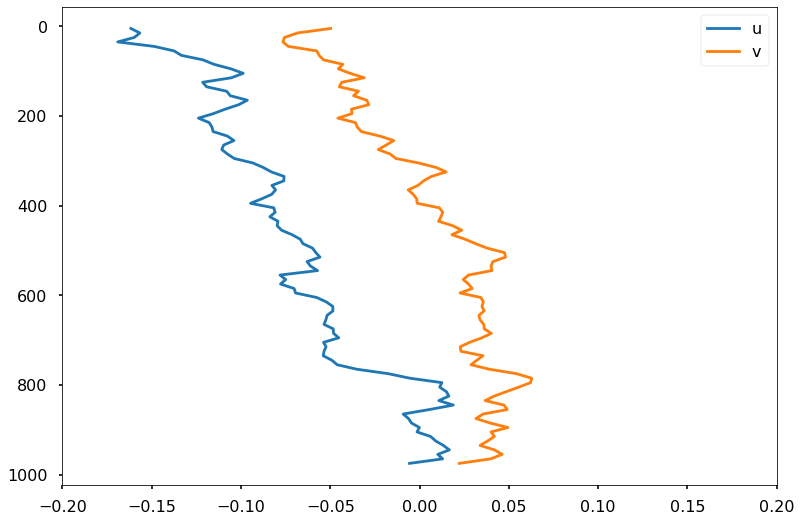

In [35]:
plt.plot(np.real(O_ls_smooth),bin_new,label='u')
plt.plot(np.imag(O_ls_smooth),bin_new,label='v')
plt.gca().invert_yaxis()
plt.xlim(-0.2,0.2)
plt.legend()

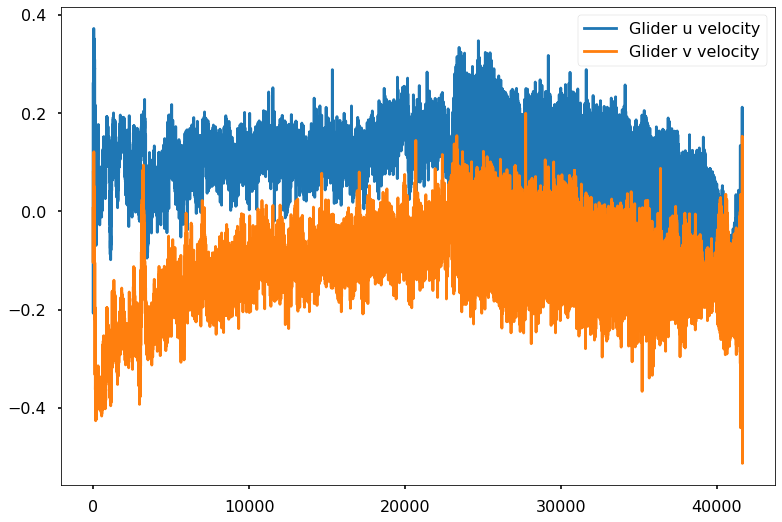

In [36]:
plt.plot(np.real(G_ls),label='Glider u velocity')
plt.plot(np.imag(G_ls),label='Glider v velocity')
plt.legend()

In [37]:
print('vx:',vx)
print('new caculated EW DAC:',np.nanmean(np.real(O_ls)))
print('vy:',vy)
print('new caculated NS DAC:',np.nanmean(np.imag(O_ls)))

vx: -0.0665451
new caculated EW DAC: -0.06771585771241641
vy: 0.00892125
new caculated NS DAC: 0.008799016150858659


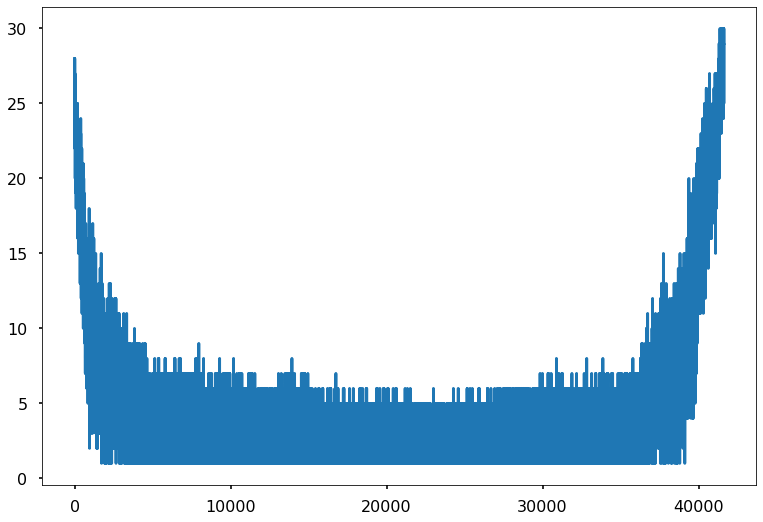

In [38]:
plt.plot(np.sum((np.isnan(U)==False),axis=0))

# Testing and Data Exploration

### Checking on pitch vattery-dependent magnetic heading correction

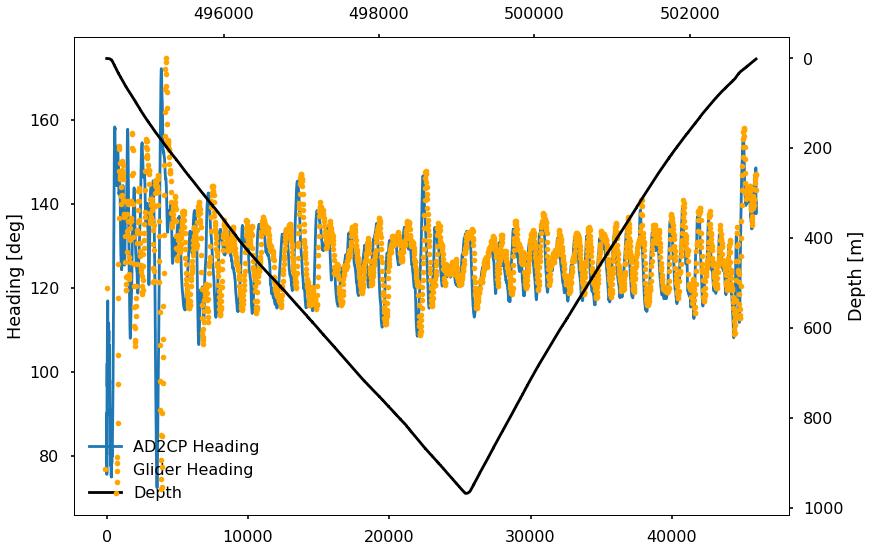

In [42]:
# x=28
# subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
# ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
# subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])


fig,ax = plt.subplots()

ln1 = ax.plot(subset_ad2cp.Heading.values,label='AD2CP Heading')
ax2=ax.twiny()
ln2 = ax2.plot(np.rad2deg(subsetgdf.m_heading),'.',color='orange',label='Glider Heading')
ax.set_ylabel('Heading [deg]')
ax3=ax.twinx()
ln3 = ax3.plot(subset_ad2cp.Pressure.values,color='black',label='Depth')
ax3.invert_yaxis()
ax3.set_ylabel('Depth [m]')
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower left',frameon=False)

### Sweet, data looks good.